In [20]:
import random
import pandas as pd
import numpy as np
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import multiprocessing
import my_decision_tree
import my_neural_network
import my_logistic_regression

**['area code', 'international plan', 'number vmail messages', 'total day calls', 'total day charge', 'total eve charge', 'total night calls', 'total night charge', 'total intl calls', 'total intl charge', 'customer service calls']**

In [2]:
df1_train = pd.read_pickle("./df1_reduced_train.pkl")
df1_test  = pd.read_pickle("./df1_reduced_test.pkl")

print(str(len(df1_train))+" "+str(len(df1_test)))
df1_test.head(3)

2661 672


,account length,area code,international plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls,churn
phone number,,,,,,,,,,,,,,
0,128.0,415.0,0.0,25.0,110.0,45.07,99.0,16.78,91.0,11.01,3.0,2.70,1.0,0.0
1,141.0,415.0,1.0,37.0,84.0,43.96,111.0,18.87,97.0,14.69,5.0,3.02,0.0,0.0
2,85.0,408.0,0.0,27.0,139.0,33.39,90.0,23.88,75.0,4.02,4.0,3.73,1.0,0.0


In [ ]:
'''
def get_selective_data(col_names):    #col_names : list
    col_names     = col_names + ['churn']
    df_train      = df1_train[col_names]
    df_test       = df1_test[col_names]
    X_train       = df_train.iloc[:,:-1]
    y_train       = df_train.iloc[:,-1:]
    X_test        = df_test.iloc[:,:-1]
    y_test        = df_test.iloc[:,-1:]
    
    scaler        = StandardScaler()
    scaler.fit(X_train)                                       
    X_train       = scaler.transform(X_train)
    X_test        = scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test

def test_parallel_model(col_names):
    X_train, y_train, X_test, y_test = get_selective_data(col_names)
    dt_y_pred_train, dt_y_pred_test = run_decission_tree(X_train, y_train, X_test, y_test, 
                                                         "entropy", "best", None, 0.01, 0.01)
    nn_y_pred_train, nn_y_pred_test = run_dnn(X_train, y_train, X_test, y_test, 
                                              'adam',0.000001, (12,12,12,6), 500, 25)
    
    truncated_y_test   =         y_test[ dt_y_pred_test == nn_y_pred_test ]
    same_pred_y_test   = dt_y_pred_test[ dt_y_pred_test == nn_y_pred_test ]
    
    return metrics.accuracy_score(truncated_y_test, same_pred_y_test)
'''

In [3]:
def get_data():
    X_train       = df1_train.iloc[:,:-1]
    y_train       = df1_train.iloc[:,-1:]
    X_test        = df1_test.iloc[:,:-1]
    y_test        = df1_test.iloc[:,-1:]
    
    scaler        = StandardScaler()
    scaler.fit(X_train)                                       
    X_train       = scaler.transform(X_train)
    X_test        = scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test

In [22]:
def run_parallel_model():
    X_train, y_train, X_test, y_test = get_data()
    
    manager     = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs        = []
    
    p = multiprocessing.Process(target=my_decision_tree.run_decission_tree, 
                                args=(0, 1, X_train, y_train, X_test, y_test, "entropy", "best", None, 0.01, 0.01, return_dict)
                               )
    jobs.append(p)
    p.start()
    
    q = multiprocessing.Process(target=my_neural_network.run_nueral_network,
                                args=(2, 3, X_train, y_train, X_test, y_test, 'adam',0.000001, (12,12,12,6), 500, 25, return_dict)
                               )
    jobs.append(q)
    q.start()
    
    for proc in jobs:
        proc.join()
    
    dt_y_pred_train     = return_dict[0]
    dt_y_pred_test      = return_dict[1]
    nn_y_pred_train     = return_dict[2]
    nn_y_pred_test      = return_dict[3]
                         
    truncated_y_train   =         y_train[ dt_y_pred_train == nn_y_pred_train ] #values of y_train when both algo in the prediction (of training set) are in accordance with each other
    same_pred_y_train   = dt_y_pred_train[ dt_y_pred_train == nn_y_pred_train ] #values of training prediction when both algo (of training set) are in accordance with each other
    conflict_y_train    =         y_train[ dt_y_pred_train != nn_y_pred_train ] #values of y_train when algos in conflict
    conflict_dt_y_train = dt_y_pred_train[ dt_y_pred_train != nn_y_pred_train ] #conflicting values singled out of prediction of each algo. (on training set)
    conflict_nn_y_train = nn_y_pred_train[ dt_y_pred_train != nn_y_pred_train ]
    
                        #similarly for test set
    truncated_y_test   =         y_test[ dt_y_pred_test == nn_y_pred_test ]
    same_pred_y_test   = dt_y_pred_test[ dt_y_pred_test == nn_y_pred_test ]
    conflict_y_test    =         y_test[ dt_y_pred_test != nn_y_pred_test ]
    conflict_dt_y_test = dt_y_pred_test[ dt_y_pred_test != nn_y_pred_test ]
    conflict_nn_y_test = nn_y_pred_test[ dt_y_pred_test != nn_y_pred_test ]
    #=================================================================================================
    truncated_cnf_matrix_train   = metrics.confusion_matrix(truncated_y_train, same_pred_y_train)/len(truncated_y_train)
    truncated_cnf_matrix_test    = metrics.confusion_matrix(truncated_y_test , same_pred_y_test )/len(truncated_y_test)
    
    class_names=[0,1]
    
    print("***************    On truncated training set    ***************")
    print("Accuracy   :",metrics.accuracy_score( truncated_y_train, same_pred_y_train))
    print("Precision  :",metrics.precision_score(truncated_y_train, same_pred_y_train))
    print("Recall     :",metrics.recall_score(   truncated_y_train, same_pred_y_train))
    print("F1 Score   :",metrics.f1_score(       truncated_y_train, same_pred_y_train))
    
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(truncated_cnf_matrix_train), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print("***************    On truncated test set    ***************")
    print("Accuracy   :",metrics.accuracy_score( truncated_y_test, same_pred_y_test))
    print("Precision  :",metrics.precision_score(truncated_y_test, same_pred_y_test))
    print("Recall     :",metrics.recall_score(   truncated_y_test, same_pred_y_test))
    print("F1 Score   :",metrics.f1_score(       truncated_y_test, same_pred_y_test))
    
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(truncated_cnf_matrix_test), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    n_train_conflict = len(conflict_y_train)
    n_test_conflict  = len(conflict_y_test)
    
    print("Conflict percentage train : ", str(round(n_train_conflict*100/len(y_train), 3)),
          " test : ", str(round(n_test_conflict*100/len(y_test),3)))
    
    conflict_X_train = X_train[list(conflict_y_train.index)]
    conflict_X_test  = X_test[list(conflict_y_test.index)]
    
    resolve_y_train, resolve_y_test = my_logistic_regression.run_logistic_regression(conflict_X_train, conflict_y_train,
                                                                                    conflict_X_test, conflict_y_test)
    
    print("----------------------------------------------- Conflict resolution training set")
    print("Accuracy   :",metrics.accuracy_score( conflict_y_train, resolve_y_train))
    print("Precision  :",metrics.precision_score(conflict_y_train, resolve_y_train))
    print("Recall     :",metrics.recall_score(   conflict_y_train, resolve_y_train))
    print("F1 Score   :",metrics.f1_score(       conflict_y_train, resolve_y_train))
    print("----------------------------------------------- Conflict resolution test set")
    print("Accuracy   :",metrics.accuracy_score( conflict_y_test,  resolve_y_test))
    print("Precision  :",metrics.precision_score(conflict_y_test,  resolve_y_test))
    print("Recall     :",metrics.recall_score(   conflict_y_test,  resolve_y_test))
    print("F1 Score   :",metrics.f1_score(       conflict_y_test,  resolve_y_test))
    
    return
#run_parallel_model()

***************    On truncated training set    ***************
Accuracy   : 0.974593092497
Precision  : 0.995391705069
Recall     : 0.774193548387
F1 Score   : 0.870967741935


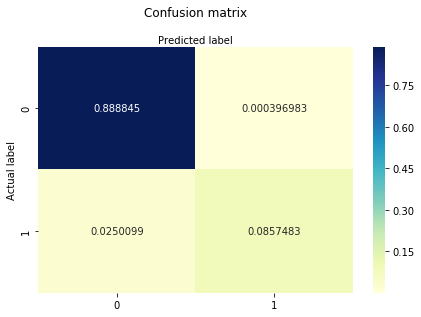

***************    On truncated test set    ***************
Accuracy   : 0.964458804523
Precision  : 1.0
Recall     : 0.661538461538
F1 Score   : 0.796296296296


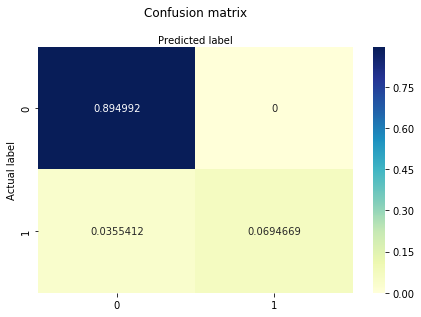

Conflict percentage train :  5.336  test :  7.887
----------------------------------------------- Conflict resolution training set
Accuracy   : 0.760563380282
Precision  : 0.7578125
Recall     : 0.97
F1 Score   : 0.850877192982
----------------------------------------------- Conflict resolution test set
Accuracy   : 0.735849056604
Precision  : 0.745098039216
Recall     : 0.974358974359
F1 Score   : 0.844444444444


F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
run_parallel_model()

In [15]:
conflict_X_train = X_train[list(conflict_y_train.index)]
conflict_X_test  = X_test[list(conflict_y_test.index)]
resolve_y_train, resolve_y_test = my_logistic_regression.run_logistic_regression(conflict_X_train, conflict_y_train,
                                                                                conflict_X_test, conflict_y_test)
print(metrics.accuracy_score(conflict_y_train, resolve_y_train))
print(metrics.accuracy_score(conflict_y_test, resolve_y_test))
#conflict__train = conflict_y_train.values
#conflict_y_test  = conflict_y_test.values
#resolve_y_train

KeyError: '[   3   27   39   45   65   76   80   86  118  120  148  154  161  201  205\n  243  249  253  270  335  345  394  395  456  459  472  489  499  525  556\n  622  644  647  652  692  695  718  720  723  756  783  814  819  857  906\n  923  944 1016 1056 1062 1081 1093 1102 1110 1112 1184 1206 1209 1244 1249\n 1252 1263 1281 1312 1339 1347 1360 1401 1410 1432 1438 1453 1471 1482 1483\n 1496 1508 1516 1541 1576 1597 1619 1623 1636 1653 1689 1721 1723 1733 1755\n 1764 1766 1768 1772 1785 1831 1849 1875 1880 1903 1908 1909 1924 1929 1934\n 1945 1948 1950 1971 2012 2031 2058 2084 2097 2099 2105 2130 2138 2141 2146\n 2161 2167 2179 2182 2226 2227 2233 2249 2252 2301 2314 2323 2359 2364 2368\n 2425 2439 2524 2527 2563 2619 2624] not in index'

0.760563380282
0.735849056604


F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
'''
def run_parallel_model():
    X_train, y_train, X_test, y_test = get_data()
    
    manager     = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs        = []
    
    p = multiprocessing.Process(target=my_decision_tree.run_decission_tree, 
                                args=(0, 1, X_train, y_train, X_test, y_test, "entropy", "best", None, 0.01, 0.01, return_dict)
                               )
    jobs.append(p)
    p.start()
    
    q = multiprocessing.Process(target=my_neural_network.run_nueral_network,
                                args=(2, 3, X_train, y_train, X_test, y_test, 'adam',0.000001, (12,12,12,6), 500, 25, return_dict)
                               )
    jobs.append(q)
    q.start()
    
    for proc in jobs:
        proc.join()
    
    dt_y_pred_train     = return_dict[0]
    dt_y_pred_test      = return_dict[1]
    nn_y_pred_train     = return_dict[2]
    nn_y_pred_test      = return_dict[3]
                         
    truncated_y_train   =         y_train[ dt_y_pred_train == nn_y_pred_train ] #values of y_train when both algo in the prediction (of training set) are in accordance with each other
    same_pred_y_train   = dt_y_pred_train[ dt_y_pred_train == nn_y_pred_train ] #values of training prediction when both algo (of training set) are in accordance with each other
    conflict_y_train    =         y_train[ dt_y_pred_train != nn_y_pred_train ] #values of y_train when algos in conflict
    conflict_dt_y_train = dt_y_pred_train[ dt_y_pred_train != nn_y_pred_train ] #conflicting values singled out of prediction of each algo. (on training set)
    conflict_nn_y_train = nn_y_pred_train[ dt_y_pred_train != nn_y_pred_train ]
    
                        #similarly for test set
    truncated_y_test   =         y_test[ dt_y_pred_test == nn_y_pred_test ]
    same_pred_y_test   = dt_y_pred_test[ dt_y_pred_test == nn_y_pred_test ]
    conflict_y_test    =         y_test[ dt_y_pred_test != nn_y_pred_test ]
    conflict_dt_y_test = dt_y_pred_test[ dt_y_pred_test != nn_y_pred_test ]
    conflict_nn_y_test = nn_y_pred_test[ dt_y_pred_test != nn_y_pred_test ]
    #=================================================================================================
    truncated_cnf_matrix_train   = metrics.confusion_matrix(truncated_y_train, same_pred_y_train)/len(truncated_y_train)
    truncated_cnf_matrix_test    = metrics.confusion_matrix(truncated_y_test , same_pred_y_test )/len(truncated_y_test)
    
    class_names=[0,1]
    
    print("***************    On truncated training set    ***************")
    print("Accuracy   :",metrics.accuracy_score( truncated_y_train, same_pred_y_train))
    print("Precision  :",metrics.precision_score(truncated_y_train, same_pred_y_train))
    print("Recall     :",metrics.recall_score(   truncated_y_train, same_pred_y_train))
    print("F1 Score   :",metrics.f1_score(       truncated_y_train, same_pred_y_train))
    
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(truncated_cnf_matrix_train), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print("***************    On truncated test set    ***************")
    print("Accuracy   :",metrics.accuracy_score( truncated_y_test, same_pred_y_test))
    print("Precision  :",metrics.precision_score(truncated_y_test, same_pred_y_test))
    print("Recall     :",metrics.recall_score(   truncated_y_test, same_pred_y_test))
    print("F1 Score   :",metrics.f1_score(       truncated_y_test, same_pred_y_test))
    
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(truncated_cnf_matrix_test), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    n_train_conflict = len(conflict_y_train)
    n_test_conflict  = len(conflict_y_test)
    
    print("Conflict percentage train : ", str(round(n_train_conflict*100/len(y_train), 3)),
          " test : ", str(round(n_test_conflict*100/len(y_test),3)))
    
    random.seed(25)
    rand_train = [random.uniform(0, 1) for i in range(n_train_conflict)]
    rand_test  = [random.uniform(0, 1) for i in range(n_test_conflict)]
    
    resolve_y_train = [conflict_dt_y_train[i] if rand_train[i]<0.5 else conflict_nn_y_train[i]
                      for i in range(n_train_conflict)]
    resolve_y_test = [conflict_dt_y_test[i]   if rand_test[i]< 0.5  else conflict_nn_y_test[i]
                      for i in range(n_test_conflict)]
    
    print("----------------------------------------------- Conflict resolution training set")
    print("Accuracy   :",metrics.accuracy_score( conflict_y_train, resolve_y_train))
    print("Precision  :",metrics.precision_score(conflict_y_train, resolve_y_train))
    print("Recall     :",metrics.recall_score(   conflict_y_train, resolve_y_train))
    print("F1 Score   :",metrics.f1_score(       conflict_y_train, resolve_y_train))
    print("----------------------------------------------- Conflict resolution test set")
    print("Accuracy   :",metrics.accuracy_score( conflict_y_test,  resolve_y_test))
    print("Precision  :",metrics.precision_score(conflict_y_test,  resolve_y_test))
    print("Recall     :",metrics.recall_score(   conflict_y_test,  resolve_y_test))
    print("F1 Score   :",metrics.f1_score(       conflict_y_test,  resolve_y_test))
    
    return X_train, y_train, X_test, y_test, conflict_y_train, resolve_y_train, conflict_y_test, resolve_y_test
#run_parallel_model()
'''